In [1]:
from pathlib import Path
import pandas as pd
from pandas.errors import EmptyDataError
from zipfile import ZipFile

In [2]:
suffix = ".csv"

_dfs = {f.name: pd.read_csv(f) for f in Path("train-data").glob("*.csv")}
 
# train_dfs = {
#     name.replace(suffix, "").replace("-train", ""): df
#     for name, df in _dfs.items()
#     if "-train" in name and len(df)
# }
dfs = {name.replace(suffix, ""): df for name, df in _dfs.items() if "-train" not in name}

# assert len(train_dfs) + len(dfs) == len(_dfs)
# print("Train dataframe:", len(train_dfs))
print("Test dataframe:", len(dfs))

Test dataframe: 3


In [3]:
df = pd.concat(dfs.values())
df.sample(n=5)

,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,no_cuda,...,_epochs,_num_examples,_train_time,damping_time,_step_time,time,step_time,damping,lr_,batch_size
46,1.590647e+09,128,128,0.010000,5.0,60,46.04416,1,0.1,False,...,1.0,50048.0,135.830323,0.000016,0.386077,1.590647e+09,0.386141,128.000000,0.1,128.0
177,1.590636e+09,128,50000,0.010000,5.0,60,179.11040,1,0.1,False,...,1.0,51200.0,141.808728,0.000016,8.931937,1.590636e+09,8.933699,3200.000000,0.1,3200.0
112,1.590627e+09,128,50000,0.010000,5.0,60,112.64000,1,0.1,False,...,1.0,50560.0,137.606070,0.000016,1.689215,1.590627e+09,1.689317,640.000000,0.1,640.0
47,1.590648e+09,128,128,0.010000,5.0,60,47.04512,1,0.1,False,...,1.0,50048.0,135.844367,0.000018,0.301651,1.590648e+09,0.301712,128.000000,0.1,128.0
1,1.590611e+09,128,1024,0.013022,5.0,5,1.00070,1,0.1,False,...,1.0,50095.0,146.387372,0.000029,0.347359,1.590611e+09,0.347429,117.508452,0.1,117.0


In [4]:
# from pprint import pprint
# pprint(list(sorted(df.columns)))

In [5]:
def get_ident(row):
    cols = [
        "dwell",
        "initial_batch_size",
        "batch_growth_rate",
        "max_batch_size",
        "momentum",
        "approx_rate",
        "lr",
        "opt_param_weight_decay"
    ]
    vals = tuple([row[c] for c in cols])
    return hash(vals)

df["ident"] = df.apply(get_ident, axis=1).apply(lambda x: "x" + str(x))

In [6]:
df["ident"].nunique()

3

In [7]:
import seaborn as sns

In [8]:
cols = ["damper", "test_accuracy", "nesterov", "ident", "dwell", "initial_batch_size", "batch_growth_rate", "max_batch_size", "momentum", "approx_rate", "lr", "opt_param_weight_decay"]
summary = pd.concat([df.iloc[-1] for df in dfs.values()], axis=1).T
summary = summary.sort_values(by="test_accuracy", ascending=False)
summary[cols]

,damper,test_accuracy,nesterov,ident,dwell,initial_batch_size,batch_growth_rate,max_batch_size,momentum,approx_rate,lr,opt_param_weight_decay
202,geodamp,0.9194,True,27ffc7caf286be78aeb22c46cec272097b3cfabc2ea3ff...,20,128,0.01,50000,0.9,False,0.1,0.0001
210,geodamplr,0.9009,True,0bdac76c5f6314b96d5a5c9722deb2e21b03d5a083ef0e...,20,128,0.01,128,0.9,False,0.1,0.0001
210,padadamp,0.9003,True,eaac1bbc04a78f228d18d65f0cc973efc84bb2a37afb09...,10,128,0.013022,1024,0.9,False,0.1,0.0001


In [9]:
df.ident.unique()

array(['x1585977512908186108', 'x-6565439405006363362',
       'x-7511406893097711922'], dtype=object)

In [10]:
summary[["damper", "ident"]]

,damper,ident
202,geodamp,27ffc7caf286be78aeb22c46cec272097b3cfabc2ea3ff...
210,geodamplr,0bdac76c5f6314b96d5a5c9722deb2e21b03d5a083ef0e...
210,padadamp,eaac1bbc04a78f228d18d65f0cc973efc84bb2a37afb09...


In [14]:
show = df.copy()

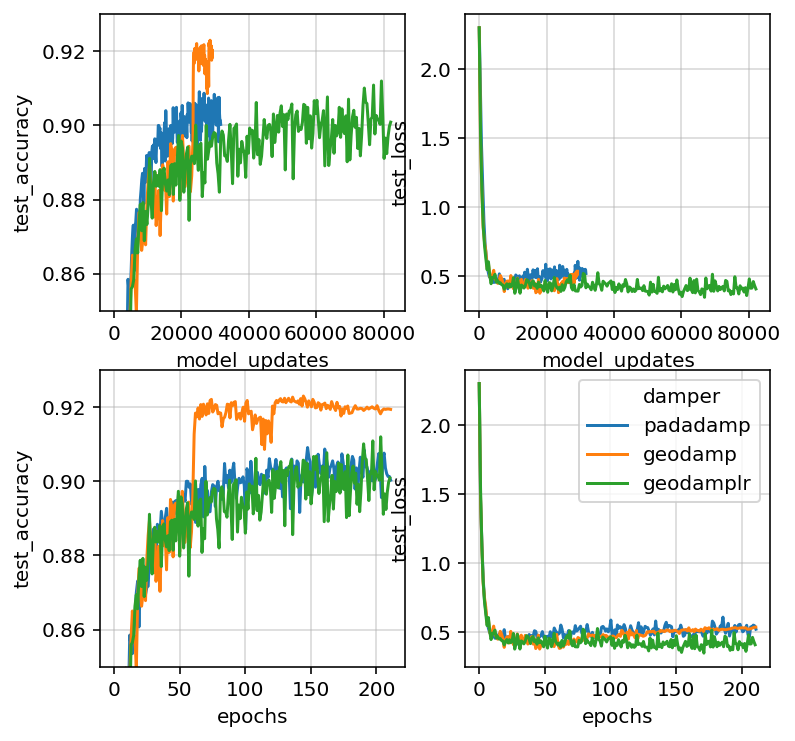

In [15]:
import matplotlib.pyplot as plt
w = 3
fig, axs = plt.subplots(figsize=(2 * w, 2 * w), nrows=2, ncols=2)

for i, x in enumerate(["model_updates", "epochs"]):
    for j, y in enumerate(["test_accuracy", "test_loss"]):
        ax = sns.lineplot(
            x=x,
            y=y,
            hue="damper",
            data=show,
            ax=axs[i, j],
        )
        if "acc" in y:
            _ = ax.set_ylim(0.85, 0.93)
#         if "updates" in x:
#             ax.set_xscale("log", basex=2)
#             ax.set_xlim(2**11, None)
        ax.grid(alpha=0.5)
        if not (i ==1 and j == 1):
            ax.legend_.remove()

In [16]:
def lineplot(show, x, y, hue="damper", hue_order=None, hues=None, labels=None, styles=None, w=3):
    if hue_order is None:
        hue_order = sorted(show.damper.unique())
    if hues is None:
        hues = [f"C{k}" for k in range(len(hue_order))]
    if styles is None:
        styles = ["-" for _ in hue_order]
    if labels is None:
        labels = {}
    fig, ax = plt.subplots(figsize=(w, w))
    for k, d in enumerate(hue_order):
        show[show[hue] == d].plot(
            x=x,
            y=y,
            linestyle=styles[k],
            color=hues[k],
            label=labels.get(d, d),
            ax=ax,
        )
    ax.grid(alpha=0.6)
    return fig, ax

In [17]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-colorblind")

DAMPERS = ["padadamp", "geodamplr", "geodamp"]
LABELS = {"padadamp": "PadaDamp", "geodamp": "GeoDamp", "geodamplr": "GeoDamp LR"}
COLORS = ["C0", "C2", "C1"]
STYLES = ["-", "--", (0, (5, 1))]

w = 2.8
kwargs = dict(hues=COLORS, hue_order=DAMPERS, styles=STYLES, labels=LABELS, w=w)

In [18]:
show.damper.unique()

array(['padadamp', 'geodamp', 'geodamplr'], dtype=object)

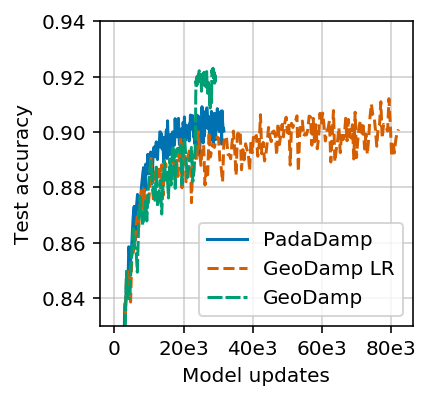

In [19]:
x = "model_updates"
y = "test_accuracy"

fig, ax = lineplot(show, x, y, **kwargs)
ax.set_ylim(0.83, 0.94)
ax.set_ylabel("Test accuracy")
ax.set_xlabel("Model updates")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{int(v / 1e3)}e3" if v > 0 else "0"))
# fmt = plt.ScalarFormatter()
# fmt.set_powerlimits((-2, 2))
# ax.xaxis.set_major_formatter(fmt)
fig.savefig("figs/cifar-mu.pdf", bbox_inches="tight")

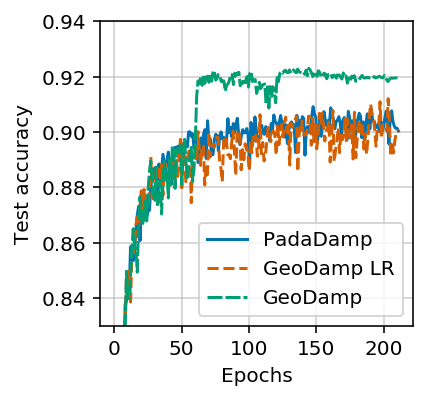

In [20]:
x = "epochs"
y = "test_accuracy"

fig, ax = lineplot(show, x, y, **kwargs)
ax.set_ylim(0.83, 0.94)
ax.set_ylabel("Test accuracy")
ax.set_xlabel("Epochs")
fig.savefig("figs/cifar-epochs.pdf", bbox_inches="tight")

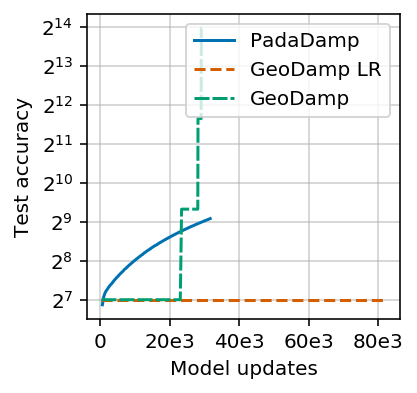

In [21]:
x = "model_updates"
y = "batch_size"

fig, ax = lineplot(show, x, y, **kwargs)
ax.set_yscale("log", basey=2)
ax.set_ylabel("Test accuracy")
ax.set_xlabel("Model updates")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{int(v / 1e3)}e3" if v > 0 else "0"))
ax.yaxis.set_major_locator(plt.FixedLocator([2**i for i in range(20)]))
ax.legend(loc="best")
fig.savefig("figs/cifar-bs.pdf", bbox_inches="tight")


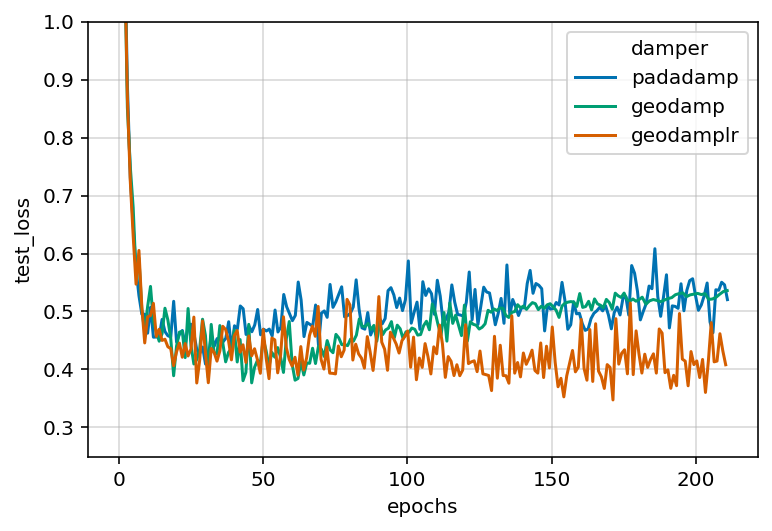

In [22]:
ax = sns.lineplot(
    x="epochs",
    y="test_loss",
    hue="damper",
    data=df[df.damper.isin(["geodamp", "padadamp", "geodamplr"])],
)
ax.set_ylim(None, 1.00)
ax.grid(alpha=0.5)

In [23]:
df.groupby("ident")["damper"].unique()

ident
x-6565439405006363362      [geodamp]
x-7511406893097711922    [geodamplr]
x1585977512908186108      [padadamp]
Name: damper, dtype: object